# Astroplan tutorial

Set up observing location:

In [45]:
from astropy.coordinates import EarthLocation
from astroplan import Observer, FixedTarget

# Where are you observing from:
address = '126 5th Ave, NY, NY'
timezeone = "US/Eastern"

location = EarthLocation.of_address(address)

observer = Observer(location=location, timezone=timezone)

Set up observing time range, set up distance from moon constraint: 

In [70]:
from astroplan import LocalTimeConstraint, MoonSeparationConstraint, AltitudeConstraint, AtNightConstraint
from datetime import time
import astropy.units as u

# Start and stop observing
start_time = time(20, 0)
end_time = time(2, 0)

# Altitude constraint
minimum_altitude = 30 * u.deg

# Minimum distance from moon: 
minimum_moon_separation = 5 * u.deg

constraints = [LocalTimeConstraint(min=start_time, max=end_time), 
               AltitudeConstraint(min=minimum_altitude), 
               AtNightConstraint.twilight_civil(), 
               MoonSeparationConstraint(min=minimum_moon_separation)]

In [71]:
from astropy.time import Time

start_date = Time('2018-05-03')
end_date = Time('2018-05-10')

from astroplan.utils import time_grid_from_range

times = time_grid_from_range([start_date, end_date], time_resolution=1*u.hour)

In [72]:
import json
from astropy.coordinates import SkyCoord, Angle
targets_json = json.load(open('targets.json', 'r'))
targets = []

for target in targets_json:
    coord = SkyCoord(ra=Angle(targets_json[target]['RA'], u.hourangle), dec=Angle(targets_json[target]['DEC'], u.degree))
    targets.append(FixedTarget(coord=coord, name=target))

In [74]:
c = AtNightConstraint.twilight_civil()

In [80]:
from astroplan import is_observable, is_always_observable
import numpy as np
observability = np.ones((len(targets), len(times))).astype(bool)

for constraint in constraints: 
    observability &= constraint(observer, targets, times, grid_times_targets=True)

In [107]:
names = [target.name for target in targets]
vmags = [targets_json[target.name]['V'] for target in targets]

import pandas as pd


table = Table(rows=[vmags], names=names).to_pandas()

In [111]:
str_times = [t.iso for t in times]

In [ ]:
np.count_nonzero()

In [137]:
df = pd.DataFrame(data=observability, columns=str_times, index=names)

filter_out_unobservable_targets = df[df.any(axis=1)]

In [145]:
np.array(filter_out_unobservable_targets.as_matrix()).shape

(46, 168)

In [171]:
ums

46

In [172]:
d = {k.iso: v for k, v in zip(times, np.sum(filter_out_unobservable_targets.as_matrix(), axis=0))}
# filter_out_unobservable_targets.sort_index(by=d)

sums = np.sum(filter_out_unobservable_targets.as_matrix(), axis=1)

filter_out_unobservable_targets['sum'] = sums

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [184]:
filter_out_unobservable_targets.sort_values('sum', ascending=False)
final_table = filter_out_unobservable_targets.drop(columns='sum')

Text(0.5,0,'Time from UTC 2018-05-03 00:00:00.000 [hrs]')

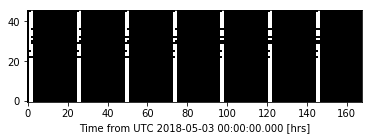

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(final_table.as_matrix(), cmap=plt.cm.Greys_r, origin='lower')
plt.xlabel('Time from UTC {0} [hrs]'.format(times[0].iso))